# Landschuetzer Global Internal Variability

Draft for code to compute internal variability magnitude in CO$_{2}$ fluxes for Landschuetzer product (remapped to POP grid). This is for comparison to Fig. 2 in the paper. Will likely be run as a .py script and visualized here.

In [177]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import esmtools as et
import numpy.polynomial.polynomial as poly
import cartopy.crs as ccrs
import matplotlib.dates as mdates

# Test Area

In [118]:
data = np.random.rand(10, 2, 2)
x = np.arange(0, len(data), 1)

In [312]:
X = np.random.rand(10,5,5)
Y = np.reshape(X)

array([[0.87661253, 0.8132321 , 0.64201166, 0.60659089, 0.71929581],
       [0.81706804, 0.87527558, 0.63970325, 0.72625316, 0.57032773],
       [0.53820097, 0.22343981, 0.6885872 , 0.19186862, 0.11841629],
       [0.58228796, 0.56164779, 0.50541474, 0.77751708, 0.81001532],
       [0.93579576, 0.0446795 , 0.7854285 , 0.52898465, 0.2232391 ]])

# Main Code

In [293]:
data = xr.open_dataset('/glade/u/home/rbrady/work/Landschuetzer_pCO2' + 
    '/spco2_1982-2015_MPI_SOM-FFN_v2016.nc')
data = data['fgco2_raw'] +30

# Is it polyfit or polyval that fucks up?

In [242]:
x = mdates.date2num(data.time)
y = np.asarray(data)
y = y.reshape(len(y), -1)
coefs = poly.polyfit(x, y, 1)

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RankWarning: The fit may be poorly conditioned
  after removing the cwd from sys.path.


In [253]:
coefs.shape

(2, 64800)

# Detrend

In [298]:
#x = np.arange(0, len(data), 1)
x = mdates.date2num(data.time)
y = np.asarray(data)
y = y.reshape(len(y), -1)

In [299]:
coefs = poly.polyfit(x, y, 1)
fit = poly.polyval(x, coefs)
#if not fit.shape == y.shape:
#    fit = np.reshape(fit, y.shape)
#y = y - fit
#y = y.reshape(len(y), data.shape[1], data.shape[2])
# warnings.simplefilter('ignore', np.RankWarning)
#data = data.to_dataset()
#data['detrended'] = (('time', 'lat', 'lon'), y)

/glade/u/home/rbrady/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RankWarning: The fit may be poorly conditioned
  """Entry point for launching an IPython kernel.


In [303]:
fit = np.reshape(fit, data.shape)
detrended = data - fit

In [306]:
# One at a time
temp = data.isel(lat=50, lon=50)
x = mdates.date2num(temp.time)
y = temp
coefs = poly.polyfit(x, y, 1)
fit = poly.polyval(x, coefs)
y = y - fit

(-5, 32)

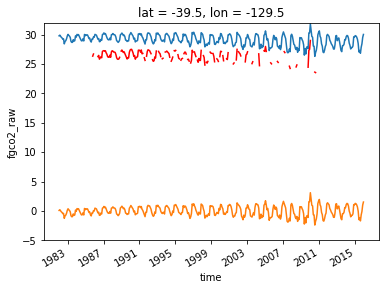

In [308]:
f, ax = plt.subplots()
data.isel(lat=50, lon=50).plot()
detrended.isel(lat=50, lon=50).plot(color='r')
plt.plot(data.time, y)
ax.set_ylim([-5, 32])

# Deseasonalize

In [97]:
clim = data.groupby('time.month').mean('time')
anom = data.groupby('time.month') - clim

# Global Std. Dev

In [98]:
internal = anom.std('time')

In [99]:
import cartopy.util as cu
import cmocean.cm as cm
cdata, clons = cu.add_cyclic_point(internal.values, coord=internal.lon)

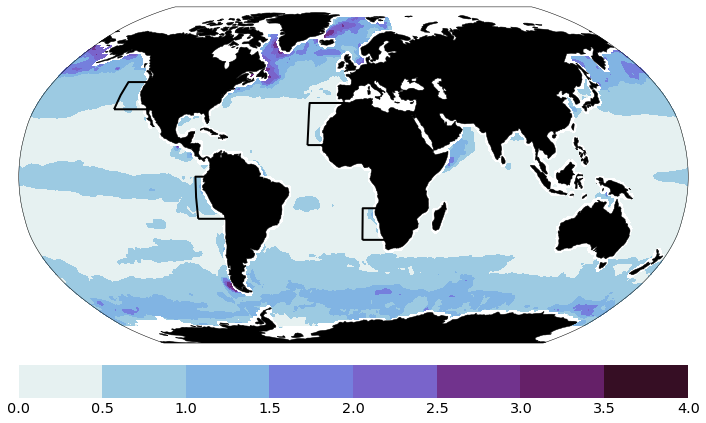

In [101]:
plt.style.use('ocn-clim')
f, ax = et.vis.make_cartopy(grid_lines=False)
m = ax.contourf(clons, internal.lat, cdata, 
                np.arange(0,4.1,0.5),transform=ccrs.PlateCarree(),
                cmap=et.vis.discrete_cmap(12, cm.dense))
cb = plt.colorbar(m, ax=ax, orientation='horizontal', pad=0.05,
                  extend='max')

# Add boxes over EBUs.
systems = ['CalCS', 'HumCS', 'CanCS', 'BenCS']
for ebu in systems:
    x0,x1,y0,y1 = et.ebus.visual_bounds(ebu, std_lon=True)
    et.vis.add_box(ax, x0,x1,y0,y1, edgecolor='k', facecolor='none', 
                   linewidth=2, alpha=1)

#et.vis.savefig('absolute_internal_magnitude', extension='.eps',  dpi=300)